Below is an example of how you might restructure and reword your Jupyter Notebook so it reads more like a polished portfolio project rather than a homework assignment. The core functionality and code remain the same—since you mentioned you built it largely from scratch, we’ll highlight that throughout. Feel free to adjust wording as you see fit.

---

# **Graph Clustering and Laplacian Embeddings (From Scratch)**

**Author:** Kaj Hansteen Izora

This project demonstrates how to perform community detection (clustering) and dimensionality reduction (via Laplacian embeddings) for graphs. The key feature of this project is that many of the standard graph algorithms (Fiedler method, maximum modularity, and recursive modularity clustering) were built from the ground up, showcasing a deeper understanding of how these methods work under the hood.

Along the way, we will:

- Construct synthetic graphs with known cluster structure.
- Implement a **Fiedler method** (a spectral partitioning technique) from scratch.
- Implement **maximum modularity**-based partitioning and a **recursive** clustering approach that refines communities.
- Build a **graph Laplacian embedding** method for low-dimensional visualization.
- Visualize clusters and compare them to the underlying synthetic “ground truth.”

We use Python libraries such as `networkx` (for graph creation/manipulation) and `numpy`, `matplotlib`, and `scipy` (for matrix operations and plotting).  

---

## **1. Imports and Basic Setup**

In [1]:
import networkx as nx
import scipy as sc
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Just a convenience setting for plotting aesthetics
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 120

---

## **2. Synthetic Graph Creation**

To showcase the clustering and embedding approaches, we first create a function that generates a synthetic graph with a known cluster structure. This allows us to test and visualize our algorithms.

In [2]:
def create_graph(cluster_size, num_clusters, connectivity):
    """
    Creates a synthetic graph with specified clusters and connectivity.

    Parameters:
    -----------
    cluster_size : int
        Number of nodes per cluster.
    num_clusters : int
        How many distinct clusters to generate.
    connectivity : float
        A parameter indicating how many inter-cluster edges to add 
        (higher = more inter-cluster edges).

    Returns:
    --------
    G : networkx.Graph
        The generated graph with (cluster_size * num_clusters) nodes.
    """
    G = nx.Graph()
    
    # First, fully connect each cluster individually
    for ic in range(num_clusters):
        offset = ic * cluster_size
        for iv in range(cluster_size):
            for jv in range(cluster_size):
                if iv != jv:
                    G.add_edge(offset + iv, offset + jv)
    
    # Add a few edges between consecutive clusters to simulate "connectivity"
    n = round(connectivity * cluster_size)
    for ic1 in range(num_clusters - 1):
        p1 = np.random.permutation(n)
        ic2 = ic1 + 1
        for i in p1:
            p2 = np.random.permutation(n)
            for j in p2:
                G.add_edge(ic1 * cluster_size + i, ic2 * cluster_size + j)

    return G

**Quick Test**  
Let’s create a small graph with two clusters (20 nodes each) and connectivity of 0.1, then visualize:

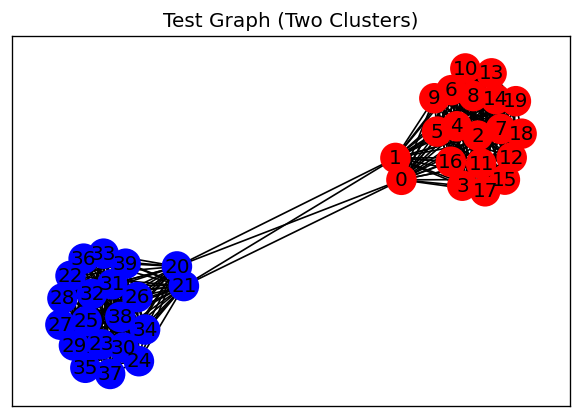

In [3]:
cluster_size = 20
num_clusters = 2
connectivity = 0.1

G_test = create_graph(cluster_size, num_clusters, connectivity)

# Color the first 20 nodes 'red' and the next 20 'blue'
node_color = ["red" if i < cluster_size else "blue" for i in range(cluster_size * num_clusters)]

plt.figure(figsize=(6,4))
nx.draw_networkx(G_test, node_color=node_color, with_labels=True)
plt.title("Test Graph (Two Clusters)")
plt.show()

---

## **3. Fiedler Method (Spectral Partitioning)**

### **3.1 Overview**
The **Fiedler vector** is the eigenvector corresponding to the second-smallest eigenvalue of the graph Laplacian. Its sign pattern can be used to split the graph into two partitions. This is a classic spectral clustering approach.

### **3.2 Implementation**

In [4]:
def fiedler(G):
    """
    Partitions the graph into two clusters using the Fiedler vector.

    Parameters:
    -----------
    G : networkx.Graph
        The input graph.

    Returns:
    --------
    (p1, p2) : tuple of lists
        p1 and p2 are the node indices for each partition.
    """
    # Laplacian matrix in sparse form, converted to float type
    L = nx.laplacian_matrix(G).astype("d")

    # Compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = sc.sparse.linalg.eigs(L, k=2, which='SM')

    # Identify the Fiedler vector: the eigenvector for the second-smallest eigenvalue
    sorted_indices = np.argsort(eigenvalues)
    fiedler_idx = sorted_indices[1]  # index of second-smallest eigenvalue
    fiedler_vector = eigenvectors[:, fiedler_idx].real  # ensure real part
    
    # Partition based on sign of Fiedler vector
    p1, p2 = [], []
    for i, val in enumerate(fiedler_vector):
        if val >= 0:
            p1.append(i)
        else:
            p2.append(i)
    
    return (p1, p2)

### **3.3 Testing the Fiedler Method**

Partition 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Partition 2: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


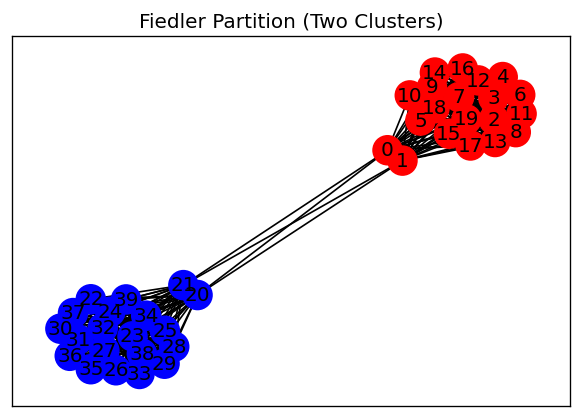

In [5]:
# Recreate or reuse our small test graph
G_test = create_graph(cluster_size=20, num_clusters=2, connectivity=0.1)

p1, p2 = fiedler(G_test)
print("Partition 1:", p1)
print("Partition 2:", p2)

# Quick visualization
node_color_fiedler = []
for i in range(40):
    if i in p1:
        node_color_fiedler.append("red")
    else:
        node_color_fiedler.append("blue")

plt.figure(figsize=(6,4))
nx.draw_networkx(G_test, node_color=node_color_fiedler, with_labels=True)
plt.title("Fiedler Partition (Two Clusters)")
plt.show()

You should see that nodes 0–19 end up in one cluster and 20–39 end up in the other, matching the synthetic labels we built in.

---

## **4. Maximum Modularity Clustering**

### **4.1 Overview**
**Modularity** is a measure of the structure of networks or graphs which measures the density of links inside communities compared to links between communities. One can form a “modularity matrix,” then partition nodes using the eigenvector corresponding to the largest eigenvalue of a certain modified matrix.

### **4.2 Modified Modularity Matrix Function**

In [6]:
def modified_modularity_matrix(G, nodes):
    """
    Extract the submatrix of the modularity matrix for the specified nodes,
    then subtract its diagonal (forming the "modified" matrix).

    Parameters:
    -----------
    G : networkx.Graph
    nodes : list or array of node indices

    Returns:
    --------
    M_mod : np.ndarray
        The modified modularity submatrix.
    """
    M = nx.modularity_matrix(G)
    submatrix = M[nodes, :][:, nodes]
    diagonal_matrix = np.diag(np.diag(submatrix))
    M_mod = submatrix - diagonal_matrix
    return M_mod

### **4.3 One-Level Maximum Modularity Partition**

In [7]:
def maximum_modularity(G, nodes):
    """
    Splits a set of nodes into two partitions based on maximum modularity eigenvector.

    Parameters:
    -----------
    G : networkx.Graph
    nodes : list of node indices

    Returns:
    --------
    partition1, partition2 : lists
        Node indices for each partition.
    largest_eigenvalue : float
        The largest eigenvalue found in the modified modularity matrix.
    """
    # Compute the modified modularity matrix
    M_mod = modified_modularity_matrix(G, nodes)
    
    # Compute eigenvalues, eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(M_mod)
    
    # Find largest eigenvalue + corresponding eigenvector
    largest_eigenvalue = np.max(eigenvalues)
    idx_largest = np.argmax(eigenvalues)
    largest_eigenvector = eigenvectors[:, idx_largest]
    
    # Partition based on sign
    partition1 = [nodes[i] for i in range(len(nodes)) if largest_eigenvector[i] > 0]
    partition2 = [nodes[i] for i in range(len(nodes)) if largest_eigenvector[i] <= 0]
    
    return partition1, partition2, largest_eigenvalue

### **4.4 Recursive Maximum Modularity Partition**

In [8]:
def recursive_maximum_modularity(G, tolerance=1e-8):
    """
    Performs a recursive partitioning of the graph nodes based on maximum modularity,
    until the largest eigenvalue drops below a specified tolerance or no further splitting is possible.

    Parameters:
    -----------
    G : networkx.Graph
    tolerance : float
        A threshold for deciding when to stop splitting based on eigenvalue magnitude.

    Returns:
    --------
    clusters : list of lists
        Each element is a list of node indices corresponding to a final cluster.
    """
    nodes = np.array(G.nodes())
    stack = [nodes]
    clusters = []

    while stack:
        current_nodes = stack.pop()
        
        if len(current_nodes) <= 1:
            # Can't split a single node further
            clusters.append(current_nodes.tolist())
            continue
        
        # Try to split
        p1, p2, largest_eig = maximum_modularity(G, current_nodes)
        
        # If eigenvalue is too small or partitions are degenerate, just finalize current set
        if largest_eig < tolerance or len(p1) == 0 or len(p2) == 0:
            clusters.append(current_nodes.tolist())
        else:
            # Otherwise push each partition back on the stack to continue splitting
            stack.append(np.array(p1))
            stack.append(np.array(p2))
    
    return clusters

### **4.5 Testing with a Multi-Cluster Graph**

Clusters found: [[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79], [80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]]


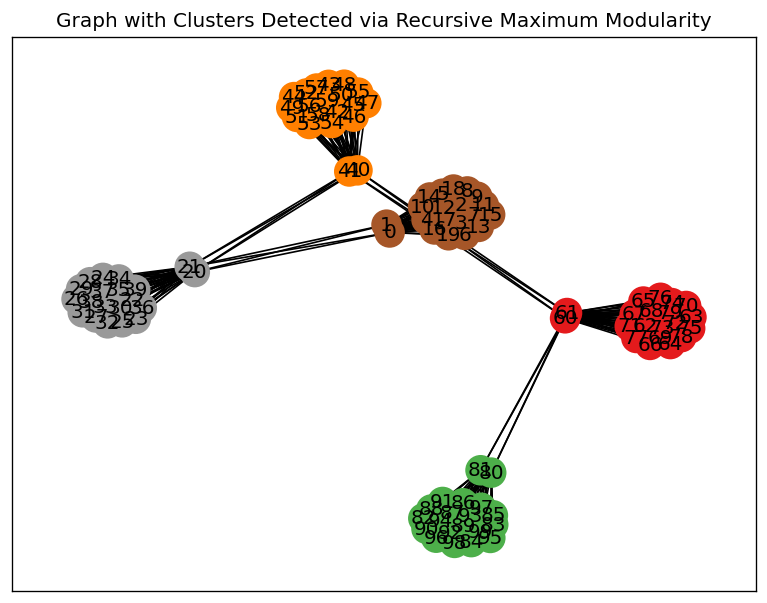

In [9]:
# Create a graph with 5 clusters, each of size 20
cluster_size = 20
num_clusters = 5
connectivity = 0.1

G_5 = create_graph(cluster_size, num_clusters, connectivity)

# Perform recursive modularity clustering
clusters = recursive_maximum_modularity(G_5)

print("Clusters found:", clusters)

# Color each node by the cluster index
node_color = np.empty(len(G_5.nodes()), dtype=int)
for cluster_index, cluster in enumerate(clusters):
    for node in cluster:
        node_color[node] = cluster_index

# Visualize the result
plt.figure(figsize=(8, 6))
nx.draw_networkx(G_5, node_color=node_color, cmap=plt.cm.Set1, with_labels=True)
plt.title("Graph with Clusters Detected via Recursive Maximum Modularity")
plt.show()

You should see that most nodes form small, tight communities (roughly matching the synthetic clusters). Variations can occur depending on the random edges between clusters.

---

## **5. Graph Laplacian Embeddings**

### **5.1 Overview**
A graph Laplacian embedding attempts to embed the nodes of a graph into a lower-dimensional space (e.g., 1D or 2D) in a way that respects graph connectivity. Concretely, we take the eigenvectors of the Laplacian (excluding the trivial zero eigenvalue) and use them as coordinates in the new space.

### **5.2 Implementation**

In [10]:
def embedding(G, d):
    """
    Returns the d-dimensional Laplacian embedding of the graph G.

    Parameters:
    -----------
    G : networkx.Graph
    d : int
        Number of dimensions to embed into (e.g., 1 or 2).

    Returns:
    --------
    coords : np.ndarray
        A d x n array of node coordinates (transposed eigenvectors).
    """
    # Create dense Laplacian
    L = nx.laplacian_matrix(G).todense()
    
    # Compute eigenvalues/eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(L)
    
    # Sort
    idx = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Skip the first eigenvector (associated with eigenvalue 0).
    # Take the next d eigenvectors as the embedding.
    embedding_vectors = eigenvectors[:, 1:d+1]
    
    # coords is shaped d x n (transpose for easy plotting)
    coords = embedding_vectors.T
    return coords

### **5.3 Visualization in 1D and 2D**

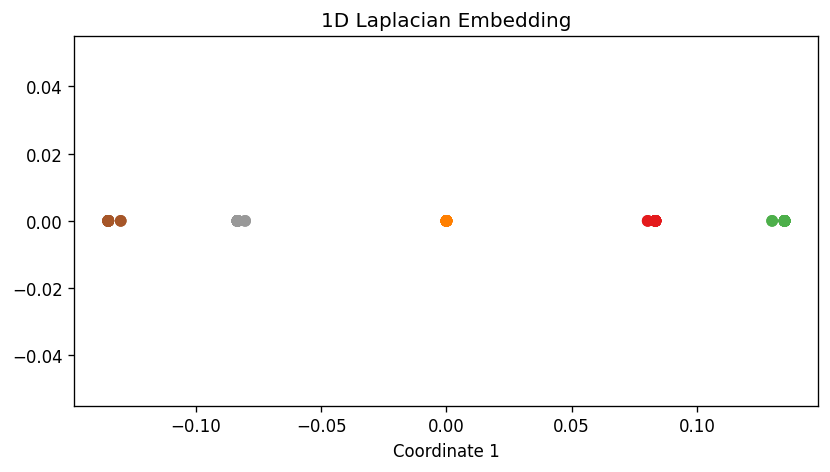

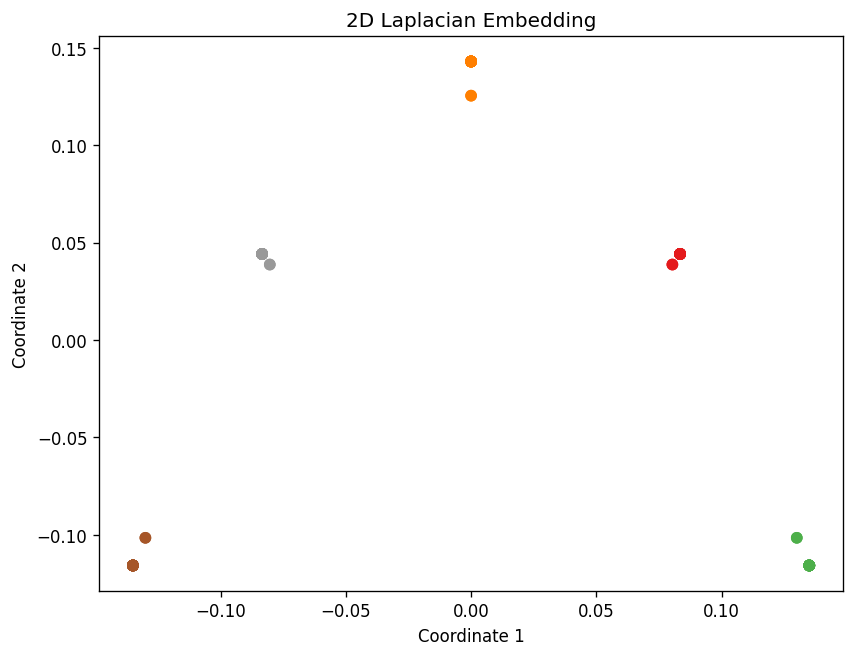

In [11]:
# We'll embed the same 5-cluster graph (G_5) in 1D and 2D

# We already have color assignments from the modularity clustering
# But keep in mind, your 'clusters' from the max_modularity approach
# might not strictly match the synthetic clusters we originally created.
# If you'd rather color by the synthetic cluster, you can re-create it here.

# 1D Embedding
coords_1d = embedding(G_5, d=1)

plt.figure(figsize=(8,4))
plt.scatter(coords_1d[0], np.zeros_like(coords_1d[0]), c=node_color, cmap=plt.cm.Set1)
plt.title("1D Laplacian Embedding")
plt.xlabel("Coordinate 1")
plt.show()

# 2D Embedding
coords_2d = embedding(G_5, d=2)

plt.figure(figsize=(8,6))
plt.scatter(coords_2d[0], coords_2d[1], c=node_color, cmap=plt.cm.Set1)
plt.title("2D Laplacian Embedding")
plt.xlabel("Coordinate 1")
plt.ylabel("Coordinate 2")
plt.show()

You should see (in both 1D and 2D plots) that nodes which belong to the same cluster tend to lie close together. The 1D plot is essentially a line, while 2D provides a more spread-out view.

---

# **Summary and Reflections**

In this project, we constructed synthetic cluster graphs with known structures to test various graph algorithms and clustering techniques. We began by implementing the Fiedler method entirely from scratch, which relies on the second-smallest eigenvalue of the Laplacian to partition a graph into two distinct communities. We also developed a maximum modularity method, alongside a recursive approach, to refine and identify multiple communities when more than two clusters are present. In addition, the project includes a Laplacian embedding function that maps the graph into a lower-dimensional space for enhanced visualization.

By avoiding black-box solutions and building these methods from first principles, we gained deeper insight into the mechanics of spectral graph theory, particularly the significance of the Laplacian matrix, the role of eigen decomposition, and how these concepts translate into practical community detection. Our workflow combined these theoretical ideas with extensive use of Python libraries such as NumPy, NetworkX, and Matplotlib, demonstrating how to handle data structures, perform linear algebra operations, and create informative visualizations.

The outcomes confirmed our intuition about how clusters form and separate, revealing both the power and limitations of these spectral methods under different connectivity regimes. Although our approach worked well for the synthetic graphs tested, future exploration could involve adjusting connectivity parameters, altering the number of clusters, or applying these techniques to larger and more complex graphs. Dense inter-cluster edges, for instance, can blur community boundaries and introduce interesting challenges in graph partitioning. Overall, these from-scratch implementations of Fiedler’s method, maximum modularity clustering, and Laplacian embedding serve as a robust demonstration of both foundational graph theory concepts and practical coding proficiency in Python.

Thank you for reading, and if you have any questions or suggestions, feel free to reach out or open an issue on my GitHub.